In [1]:
import os
import string
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg16 import VGG16,preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical,plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from tensorflow.keras.models import Model
import pickle


2025-06-10 04:17:21.383557: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749529041.604540      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749529041.667392      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
BASE_DIR='/kaggle/input/flickr8k'
WORKING_DIR='/kaggle/working'    

In [3]:
#extract image 
model=VGG16()
model=Model(inputs=model.inputs, outputs=model.layers[-2].output)

print(model.summary())

I0000 00:00:1749529063.427535      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1749529063.428228      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


In [4]:
#extract feature from image 
features={}
directory=os.path.join(BASE_DIR,'Images')

for img_name in tqdm(os.listdir(directory)):

    img_path=directory + '/' + img_name
    image=load_img(img_path, target_size=(224,224))
    image=img_to_array(image)
    image=image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image=preprocess_input(image)
    feature=model.predict(image, verbose=0)
    image_id=img_name.split('.')[0]
    features[image_id]=feature



  0%|          | 0/8091 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
I0000 00:00:1749529080.295817      96 service.cc:148] XLA service 0x7b6118004f70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749529080.296739      96 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1749529080.296757      96 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1749529080.439115      96 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1749529083.047277      96 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
100%|██████████| 8091/8091 [12:54<00:00, 10.45it/s]


In [5]:
#load the caption data

with open(os.path.join(BASE_DIR,'captions.txt'), 'r') as f:
    next(f)
    captions_doc=f.read()

In [6]:
mapping={}

for line in tqdm(captions_doc.split('\n')):
    tokens= line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    image_id = image_id.split('.')[0]
    caption = " ".join(caption)
    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].append(caption)

100%|██████████| 40456/40456 [00:00<00:00, 775209.18it/s]


In [7]:
len(mapping)

8091

In [8]:
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [9]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]
            caption = caption.lower()
            caption = caption.replace('[^A-Za-z]','')
            caption = caption.replace('\s+',' ')
            caption = 'start ' + " ".join([word for word in caption.split() if len(word)>1]) + ' end'
            captions[i] = caption
        

In [10]:
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [11]:
clean(mapping)

In [12]:
mapping['1000268201_693b08cb0e']

['start child in pink dress is climbing up set of stairs in an entry way end',
 'start girl going into wooden building end',
 'start little girl climbing into wooden playhouse end',
 'start little girl climbing the stairs to her playhouse end',
 'start little girl in pink dress going into wooden cabin end']

In [13]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [14]:
len(all_captions)

40455

In [15]:
all_captions[:10]

['start child in pink dress is climbing up set of stairs in an entry way end',
 'start girl going into wooden building end',
 'start little girl climbing into wooden playhouse end',
 'start little girl climbing the stairs to her playhouse end',
 'start little girl in pink dress going into wooden cabin end',
 'start black dog and spotted dog are fighting end',
 'start black dog and tri-colored dog playing with each other on the road end',
 'start black dog and white dog with brown spots are staring at each other in the street end',
 'start two dogs of different breeds looking at each other on the road end',
 'start two dogs on pavement moving toward each other end']

In [16]:
#tokenize 

tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [17]:
vocab_size

8483

In [18]:
import pickle

# Save the tokenizer to a file
with open('tokenizer1.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [19]:
#get maximum length of the caption 

max_length=max(len(caption.split()) for caption in all_captions)
max_length

35

In [20]:
#train test split

image_ids=list(mapping.keys())
split=int(len(image_ids) * 0.90)
train=image_ids[:split]
test=image_ids[split:]


In [22]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = list(), list(), list()
    n = 0
    while True:
        for key in data_keys:
            captions = mapping[key]
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(features[key][0])  # shape: (2048,)
                    X2.append(in_seq)            # shape: (max_length,)
                    y.append(out_seq)            # shape: (vocab_size,)
                    n += 1

                    if n == batch_size:
                        yield ((np.array(X1), np.array(X2)), np.array(y))
                        X1, X2, y = list(), list(), list()
                        n = 0


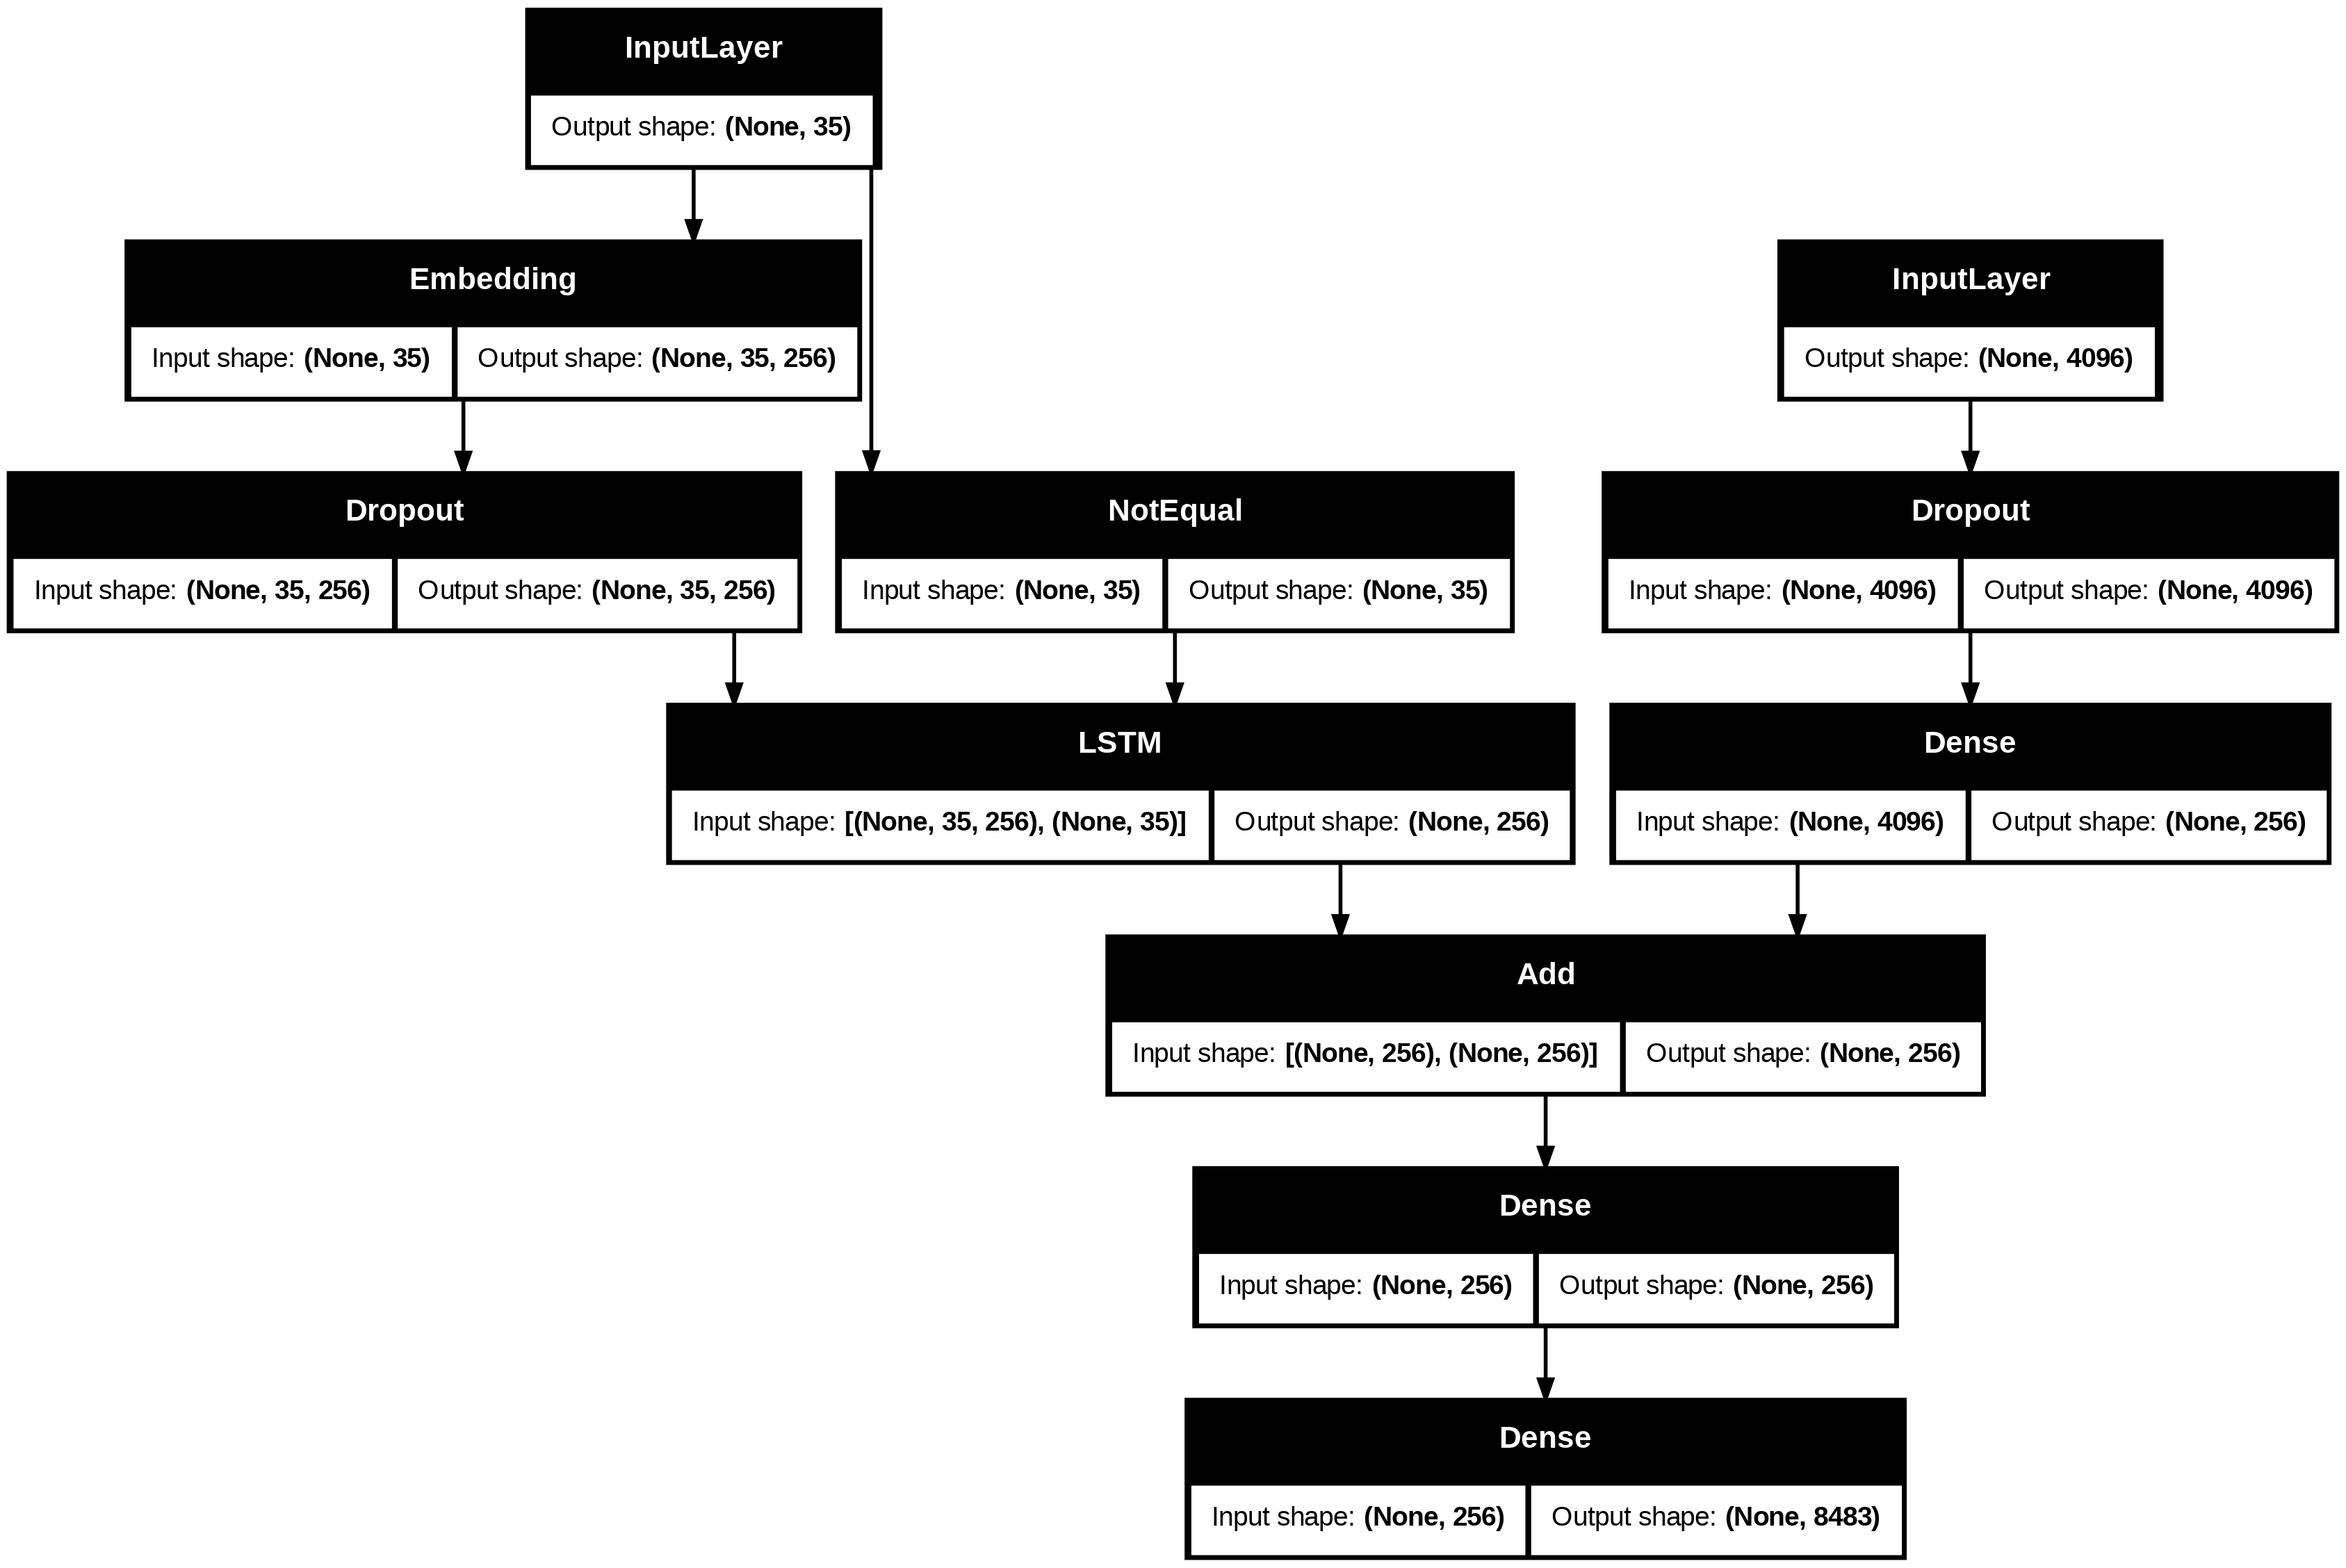

In [23]:
#model creation

inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size,256,mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256,activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model=Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy',optimizer='adam')

plot_model(model, show_shapes=True)

In [25]:
import tensorflow as tf

# Use the correct feature_dim
feature_dim = 4096

dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size),
    output_signature=(
        (
            tf.TensorSpec(shape=(None, feature_dim), dtype=tf.float32),   # image features
            tf.TensorSpec(shape=(None, max_length), dtype=tf.int32),      # input sequences
        ),
        tf.TensorSpec(shape=(None, vocab_size), dtype=tf.float32)         # output (one-hot)
    )
)


In [34]:
# Set parameters
epochs = 100
batch_size = 128
steps_per_epoch = len(train) // batch_size

# Train the model
model.fit(
    dataset,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    verbose=1
)


Epoch 1/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 3.8550
Epoch 2/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.0319
Epoch 3/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.9806
Epoch 4/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.0462
Epoch 5/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.9120
Epoch 6/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.0189
Epoch 7/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.1580
Epoch 8/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 3.8761
Epoch 9/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.8761
Epoch 10/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 3.7912
Epoch 11/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.6374
Epoch 12/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.6840
Epoch 13/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 3.7019
Epoch 14/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.6714
Epoch 15/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - lo

In [35]:
model.save('model4.keras')

In [28]:
#generate caption for thr image

def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [29]:


def predict_caption(model, image, tokenizer, max_length):
    in_text = 'start'
    
    for _ in range(max_length):
        # Tokenize and pad
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
        
        # Predict next word
        yhat = model.predict([image, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = tokenizer.index_word.get(yhat)
        
        if word is None:
            break

        in_text += ' ' + word
        if word =='end':
            break
    return in_text



In [30]:
#validate with test data
from nltk.translate.bleu_score import corpus_bleu

actual, predicted =list(),list()
for key in tqdm(test):
    captions=mapping[key]
    y_pred=predict_caption(model, features[key],tokenizer,max_length)
    actual_captions=[caption.split() for caption in captions]
    y_pred=y_pred.split()
    actual.append(actual_captions)
    predicted.append(y_pred)

#calculate BLEU score
print("BLEU-1: %f"% corpus_bleu(actual,predicted,weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f"% corpus_bleu(actual,predicted,weights=(0.5, 0.5, 0, 0)))

100%|██████████| 810/810 [09:29<00:00,  1.42it/s]


BLEU-1: 0.491803
BLEU-2: 0.230597


In [31]:
#visualize the result

from PIL import Image
import matplotlib.pyplot as plt


#load the image
def generate_caption(image_name):
    
    
    image_id=image_name.split('.')[0]
    img_path=os.path.join(BASE_DIR,"Images", image_name)
    image=Image.open(img_path)

    captions=mapping[image_id]
    print('--------------------actual-----------------------')
    for caption in captions:
        print(caption)
    y_pred=predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------predict------------------------')
    
    plt.imshow(image)
    plt.axis("off")
    plt.show()
    print(y_pred)

--------------------actual-----------------------
start black dog leaps over log end
start grey dog is leaping over fallen tree end
start large black dog leaps fallen log end
start mottled black and grey dog in blue collar jumping over fallen tree end
start the black dog jumped the tree stump end
--------------------predict------------------------


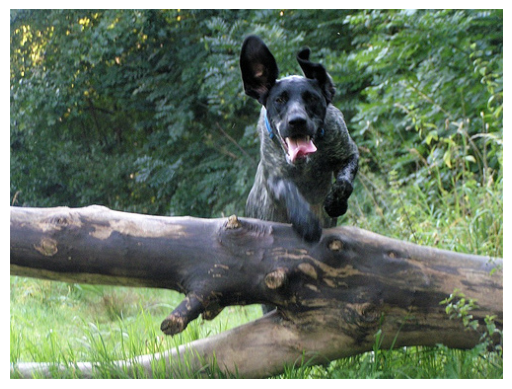

start two dogs are running through the grass end


In [33]:
generate_caption("1015584366_dfcec3c85a.jpg")